# part0: imports

In [1]:
import os, sys, pathlib
from pprint import pprint
import gc
import pickle
from importlib import reload
import logging, warnings
logging.basicConfig(level=logging.ERROR)

import pandas as pd
import numpy as np
import sklearn
from sklearn.decomposition import PCA
import scipy.linalg as linalg
import scipy.stats as stats
from sklearn.linear_model import Ridge, LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer, r2_score


import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib
from matplotlib.ticker import MaxNLocator
%matplotlib inline


import pyaldata as pyal

try:
    nbPath = pathlib.Path.cwd()
    RepoPath = nbPath.parent
    os.chdir(RepoPath)

    from tools import utilityTools as utility
    from tools import dataTools as dt
    import params
    defs = params.monkey_defs
    
    set_rc =  params.set_rc_params
    set_rc()
    root = params.root
    reload(params)
    reload(defs)

finally:
    os.chdir(nbPath)

if "__file__" not in dir():

    %run "_dataset-selection.ipynb"

the variable `GoodDataList` contains the session names


# Read data

In [161]:
ex_sessions = [0,2]

In [162]:
full_list = []
for animal, sessionList in GoodDataList[defs.areas[2]].items():
    if 'Mr' in animal:
        continue  # to remove MrT
    full_list.append((animal,sessionList))
full_list = [(animal,session) for animal,sessions in full_list for session in set(sessions)]

# load the DFs
warnings.filterwarnings("ignore")
allDFs = []
for animal, session in full_list:
    path = root / animal / session
    allDFs.append(defs.prep_general(dt.load_pyal_data(path)))
warnings.filterwarnings("default")

allDFs = [allDFs[i] for i in ex_sessions]

# Within animal, within session

Same as *"within-day"* analysis of the NN paper

In [66]:
def within_decode_score_and_traj(allDFs):

    warnings.filterwarnings("ignore")
    
    reg_scores = []
    reg_data = []
    orig_data = []
    for i, df in enumerate(allDFs):
        AllData, AllVel = defs.get_data_array_and_vel([df], defs.exec_epoch, area=defs.areas[2], n_components=defs.n_components)

        # adding history
        AllData = dt.add_history_to_data_array(AllData,defs.MAX_HISTORY)

        n_trials = int(AllData.shape[-3] /2)
        AllData1 = AllData[0,...][:,:n_trials, :,:]
        AllData2 = AllData[0,...][:,-n_trials:,:,:]
        AllVel1 = AllVel[0,...][:,:n_trials, :,:]
        AllVel2 = AllVel[0,...][:,-n_trials:,:,:]
        _,n_trial,n_time,n_comp = np.min(np.array((AllData1.shape,AllData2.shape)),axis=0)
        # resizing
        X1 = AllData1.reshape((-1,n_comp))
        X2 = AllData2.reshape((-1,n_comp))
        # controlling the size
        AllVel2 = AllVel2.reshape((-1,2))
        AllVel1 = AllVel1.reshape((-1,2))

        Y_train_x,Y_train_y = AllVel1.T
        # test the decoder
        Y_test_x,Y_test_y = AllVel2.T

        x_score=cross_val_score(LinearRegression(),np.vstack((X1,X2)),np.hstack((Y_train_x,Y_test_x)),scoring=defs.custom_r2_scorer, cv=5).mean()
        y_score=cross_val_score(LinearRegression(),np.vstack((X1,X2)),np.hstack((Y_train_y,Y_test_y)),scoring=defs.custom_r2_scorer, cv=5).mean()
        
        reg_x, reg_y = LinearRegression(), LinearRegression()
        reg_x.fit(X1, Y_train_x)
        reg_y.fit(X1, Y_train_y)
        # test the decoder
        reg_scores.append((x_score,y_score))
        reg_data.append((reg_x.predict(X2),reg_y.predict(X2)))
        orig_data.append((AllVel1,AllVel2))
    warnings.filterwarnings("default")
    
    return n_time, reg_scores, orig_data, reg_data
    

In [68]:
n_time, reg_scores, orig_data, reg_data = within_decode_score_and_traj(allDFs)

Now... Same as above, for different animals

# Across animal decoding

## With alignment 

In [49]:
def aligned_decode_score_and_traj(pairDF):
    warnings.filterwarnings("ignore")
    
    AllData, AllVel = de.get_data_array_and_vel(pairDF, defs.exec_epoch, area=defs.areas[2], n_components=defs.n_components)

    # adding history
    AllData = dt.add_history_to_data_array(AllData, defs.MAX_HISTORY)

    AllData1 = AllData[0,...]
    AllData2 = AllData[1,...]
    AllVel1 = AllVel[0,...]
    AllVel2 = AllVel[1,...]
    # resizing
    _,n_trial,n_time,n_comp = np.min(np.array((AllData1.shape,AllData2.shape)),axis=0)

    X1 = AllData1.reshape((-1,n_comp))
    X2 = AllData2.reshape((-1,n_comp))
    AllVel2 = AllVel2.reshape((-1,2))
    AllVel1 = AllVel1.reshape((-1,2))

    # train the decoder
    *_,U,V = dt.canoncorr(X1, X2, fullReturn=True)
    Y_train_x,Y_train_y = AllVel1.T

    reg_x, reg_y = LinearRegression(), LinearRegression()
    reg_x.fit(U, Y_train_x)
    reg_y.fit(U, Y_train_y)
    # test the decoder
    Y_test_x,Y_test_y = AllVel2.T
    x_score = defs.custom_r2_func(Y_test_x, reg_x.predict(V))
    y_score = defs.custom_r2_func(Y_test_y, reg_y.predict(V))
    warnings.filterwarnings("default")
    
    reg_scores = (x_score,y_score)
    reg_data = (reg_x.predict(V),reg_y.predict(V))
    orig_data = (AllVel1,AllVel2)

    return n_time, reg_scores, orig_data, reg_data

In [50]:
n_time, reg_scores, orig_data, reg_data = aligned_decode_score_and_traj(allDFs)

## Without alignment

In [53]:
def unaligned_decode_score_and_traj(pairDF):

    warnings.filterwarnings("ignore")
    AllData, AllVel = defs.get_data_array_and_vel(pairDF, defs.exec_epoch, area=defs.areas[2], n_components=defs.n_components)

    # adding history
    AllData = dt.add_history_to_data_array(AllData, defs.MAX_HISTORY)

    AllData1 = AllData[0,...]
    AllData2 = AllData[1,...]
    AllVel1 = AllVel[0,...]
    AllVel2 = AllVel[1,...]
    # resizing
    _,n_trial,n_time,n_comp = np.min(np.array((AllData1.shape,AllData2.shape)),axis=0)
    X1 = AllData1.reshape((-1,n_comp))
    X2 = AllData2.reshape((-1,n_comp))
    AllVel2 = AllVel2.reshape((-1,2))
    AllVel1 = AllVel1.reshape((-1,2))

    Y_train_x,Y_train_y = AllVel1.T

    reg_x, reg_y = LinearRegression(), LinearRegression()
    reg_x.fit(X1, Y_train_x)
    reg_y.fit(X1, Y_train_y)
    # test the decoder
    Y_test_x,Y_test_y = AllVel2.T
    x_score = defs.custom_r2_func(Y_test_x, reg_x.predict(X2))
    y_score = defs.custom_r2_func(Y_test_y, reg_y.predict(X2))
    warnings.filterwarnings("default")
    
    reg_scores = (x_score,y_score)
    reg_data = (reg_x.predict(X2),reg_y.predict(X2))
    orig_data = (AllVel1,AllVel2)

    return n_time, reg_scores, orig_data, reg_data

In [163]:
n_time, reg_scores, orig_data, reg_data = unaligned_decode_score_and_traj(allDFs)

# All in One

In [164]:
def _decode_score_and_traj(pairDF):    
    AllData, AllVel = defs.get_data_array_and_vel(pairDF, defs.exec_epoch, area=defs.areas[2], n_components=defs.n_components)
    # adding history
    AllData = dt.add_history_to_data_array(AllData, defs.MAX_HISTORY)

    AllData1 = AllData[0,...]
    AllData2 = AllData[1,...]
    AllVel1 = AllVel[0,...]
    AllVel2 = AllVel[1,...]
    # resizing
    n_target,n_trial,n_time,n_comp = np.min(np.array((AllData1.shape,AllData2.shape)),axis=0)

    X1 = AllData1.reshape((-1,n_comp))
    X2 = AllData2.reshape((-1,n_comp))
    AllVel2 = AllVel2.reshape((-1,2))
    AllVel1 = AllVel1.reshape((-1,2))

    # train the decoder
    *_,U,V = dt.canoncorr(X1, X2, fullReturn=True)
    Y_train_x,Y_train_y = AllVel1.T
    Y_test_x,Y_test_y = AllVel2.T
    reg_x, reg_y = LinearRegression(), LinearRegression()
    orig_data = (AllVel1,AllVel2)
    
    #aligned
    reg_x.fit(U, Y_train_x)
    reg_y.fit(U, Y_train_y)
    x_score = defs.custom_r2_func(Y_test_x, reg_x.predict(V))
    y_score = defs.custom_r2_func(Y_test_y, reg_y.predict(V))
    a_scores = (x_score,y_score)
    a_data = (reg_x.predict(V),reg_y.predict(V))
    
    #unaligned
    reg_x, reg_y = LinearRegression(), LinearRegression()
    reg_x.fit(X1, Y_train_x)
    reg_y.fit(X1, Y_train_y)
    x_score = defs.custom_r2_func(Y_test_x, reg_x.predict(X2))
    y_score = defs.custom_r2_func(Y_test_y, reg_y.predict(X2))
    u_scores = (x_score,y_score)
    u_data = (reg_x.predict(X2),reg_y.predict(X2))
    
    #Within
    n_trials = int(AllData.shape[-3] /2)
    AllData1 = AllData[0,...][:,:n_trials, :,:]
    AllData2 = AllData[0,...][:,-n_trials:,:,:]
    AllVel1 = AllVel[0,...][:,:n_trials, :,:]
    AllVel2 = AllVel[0,...][:,-n_trials:,:,:]
    _,ntrial,ntime,ncomp = np.min(np.array((AllData1.shape,AllData2.shape)),axis=0)
    # resizing
    X1 = AllData1.reshape((-1,ncomp))
    X2 = AllData2.reshape((-1,ncomp))
    # controlling the size
    AllVel2 = AllVel2.reshape((-1,2))
    AllVel1 = AllVel1.reshape((-1,2))

    Y_train_x,Y_train_y = AllVel1.T
    Y_test_x,Y_test_y = AllVel2.T

    x_score=cross_val_score(LinearRegression(),np.vstack((X1,X2)),np.hstack((Y_train_x,Y_test_x)),scoring=defs.custom_r2_scorer, cv=5).mean()
    y_score=cross_val_score(LinearRegression(),np.vstack((X1,X2)),np.hstack((Y_train_y,Y_test_y)),scoring=defs.custom_r2_scorer, cv=5).mean()

    reg_x, reg_y = LinearRegression(), LinearRegression()
    reg_x.fit(X1, Y_train_x)
    reg_y.fit(X1, Y_train_y)
    w_scores = (x_score,y_score)
    w_data = (reg_x.predict(X2),reg_y.predict(X2))


    return n_time, orig_data, w_data, a_data, u_data, w_scores, a_scores, u_scores

# make a figure

like the *NN 2020 - Figure 5B*  
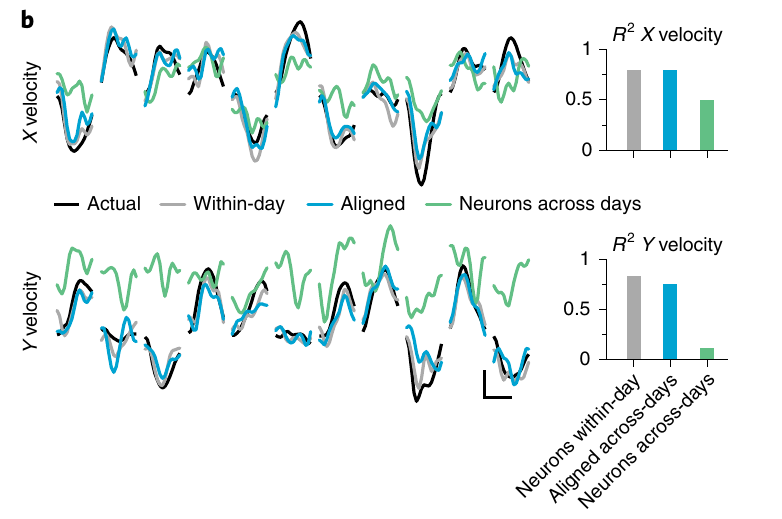

In [191]:
n_time, orig_data, w_data, a_data, u_data, w_scores, a_scores, u_scores = _decode_score_and_traj (allDFs)


# equal spaing will sample EVERY target, because the data structure was symmetric!
offset = 0
w_ind = np.linspace(offset*n_time,len(w_data[0])-((offset+1)*n_time), defs.n_targets, dtype=int)
_ind = np.linspace(offset*n_time,len(a_data[0])-((offset+1)*n_time), defs.n_targets, dtype=int)

print(n_time, _ind)

15 [   0  289  578  867 1157 1446 1735 2025]


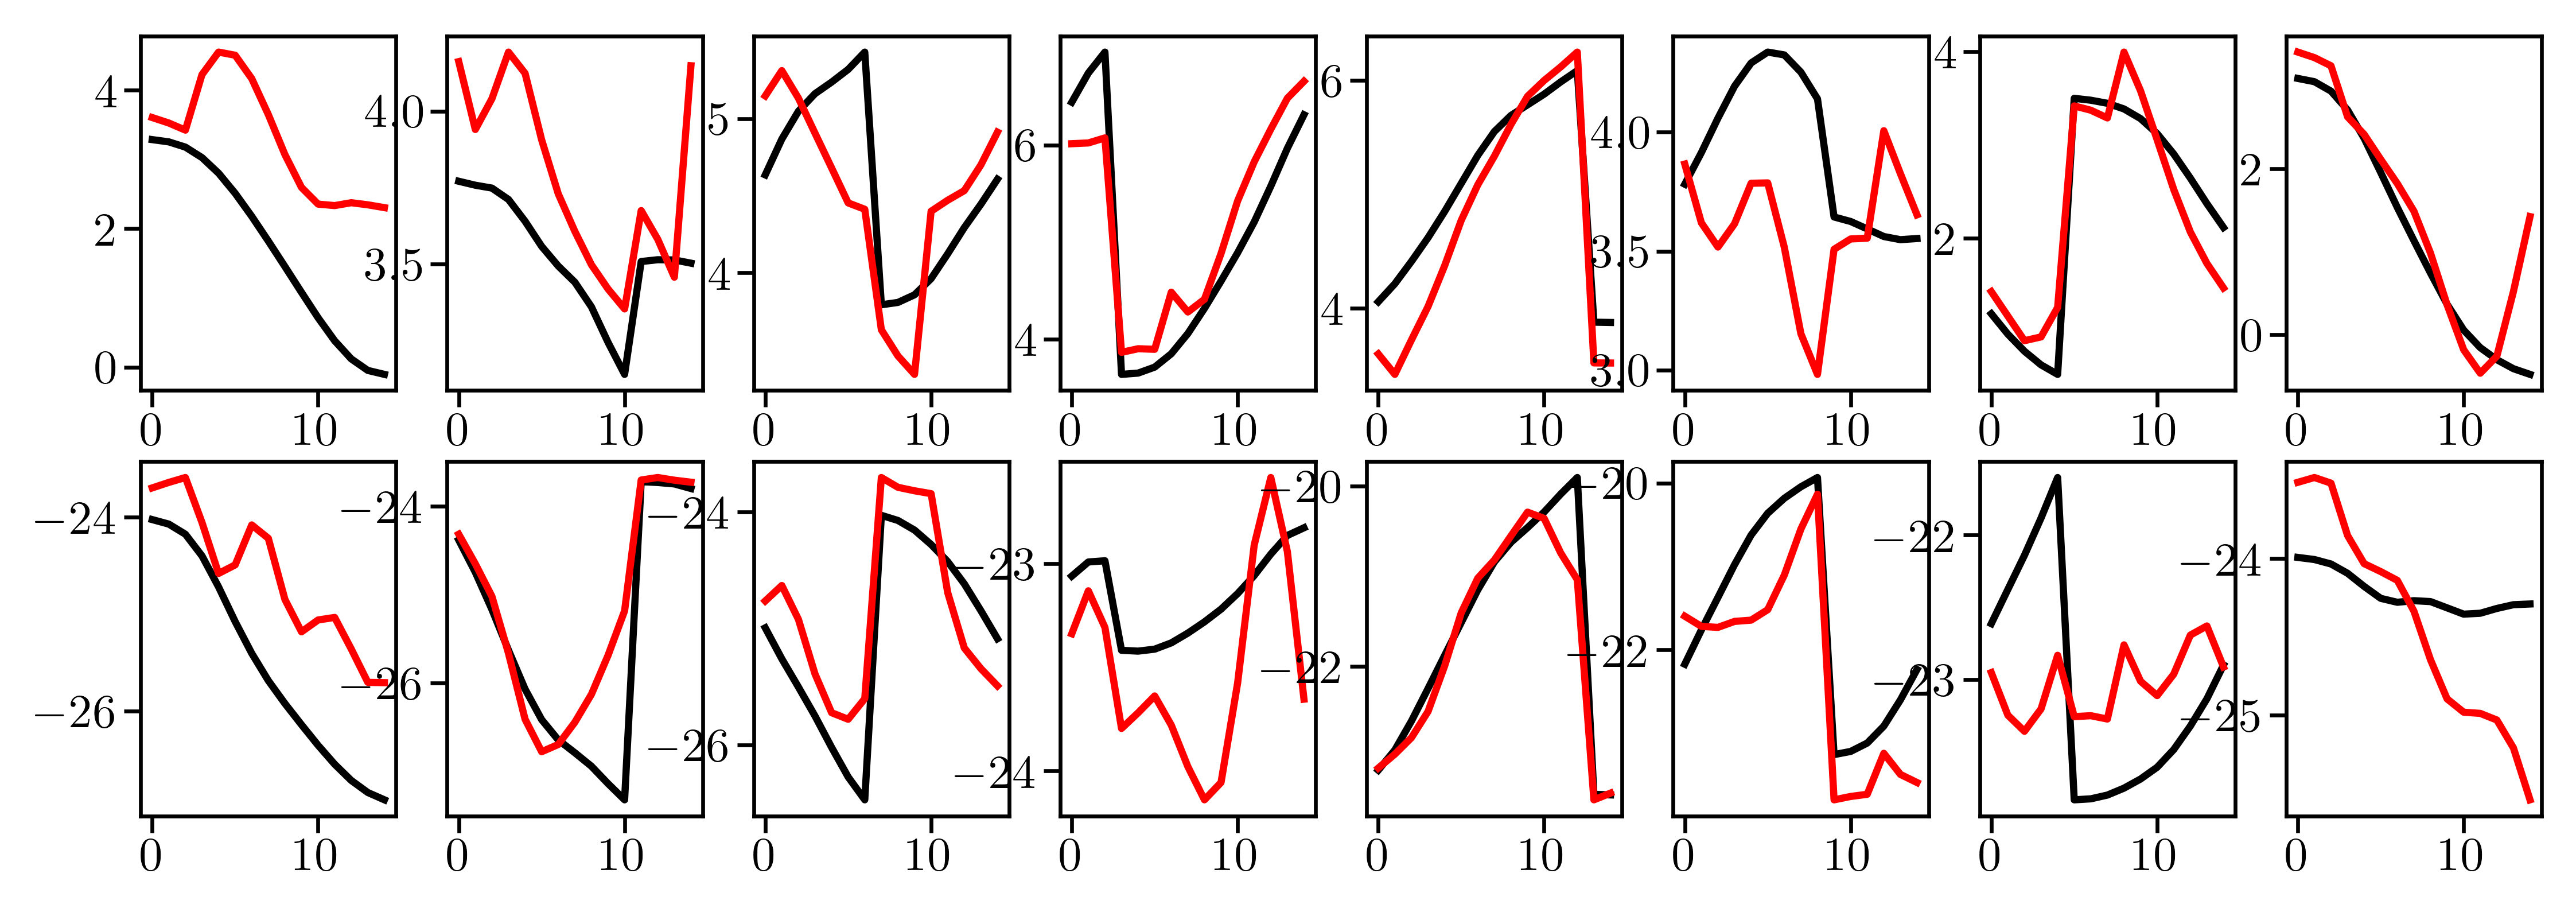

In [192]:
fig, axes = plt.subplots(ncols=defs.n_targets, nrows=2, figsize=(9,3))

for i in range(defs.n_targets):
    axx = axes[0,i]
    axy = axes[1,i]
    wi = w_ind[i]
    ai = _ind[i]

    axx.plot(orig_data[0][ai:n_time+ai,0], color='k', label='Actual')
    axy.plot(orig_data[0][ai:n_time+ai,1], color='k', label='Actual')
    
    # axx.plot(w_data[0][wi:n_time+wi], color='b', label='Within')
    # axy.plot(w_data[1][wi:n_time+wi], color='b', label='Within')

    axx.plot(a_data[0][ai:n_time+ai], color='r', label='Aligned')
    axy.plot(a_data[1][ai:n_time+ai], color='r', label='Aligned')
    
#     axx.plot(u_data[0][ai:n_time+ai], color='g', label='Unaligned')
#     axy.plot(u_data[1][ai:n_time+ai], color='g', label='Unaligned')



# histograms

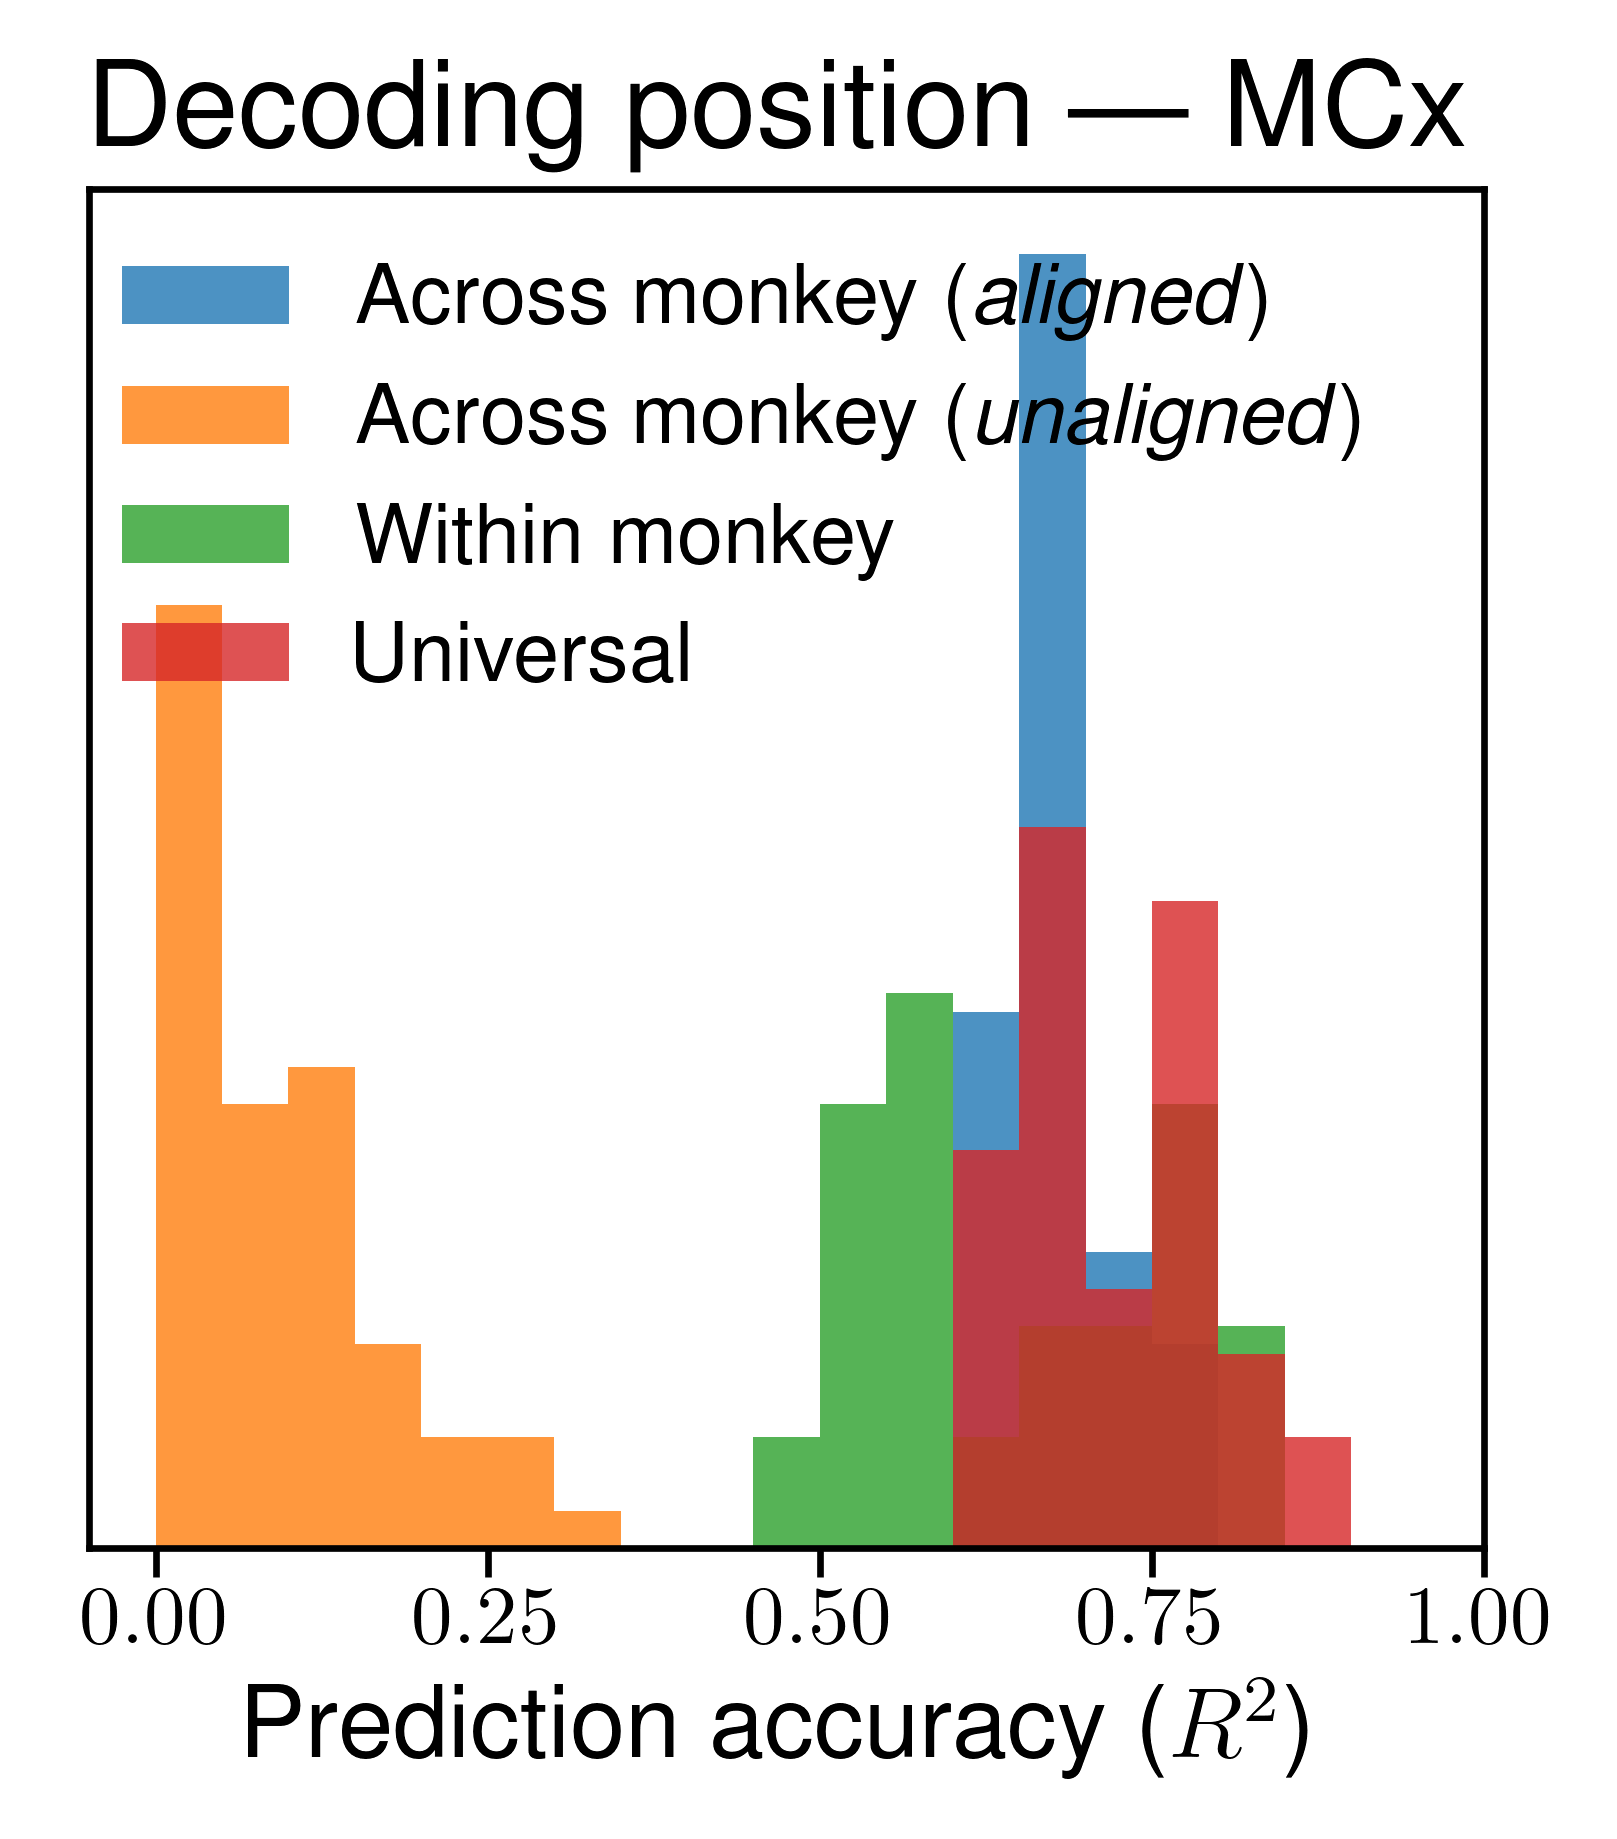

In [16]:
if "__file__" not in dir():

    fig,ax = plt.subplots(figsize=(3,3))

    bins = np.arange(0,1,0.05)
    ax.hist(pop_score_across, bins=bins, density=True, label=r'Across monkey (\textit{aligned})', alpha=.8)
    ax.hist(pop_latent_score, bins=bins, density=True, label=r'Across monkey (\textit{unaligned})', alpha=.8)
    # ax.hist(pop_score2, bins=bins, density=True, label='aligned across days', alpha=.8)
    ax.hist(pop_score_day, bins=bins, density=True, label='Within monkey', alpha=.8)
    ax.hist(pop_score_uni, bins=bins, density=True, label='Universal', alpha=.8)

    ax.set_title('Decoding position --- MCx')
    ax.set_xlabel('Prediction accuracy ($R^2$)')
    ax.set_yticks([])
    ax.set_xlim([-.05,1])
    ax.legend(loc=(0,.6))

    fig.savefig(params.figPath / 'monkey-MCx-decode.pdf', format='pdf', bbox_inches='tight')